In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install fastai==1.0.61

     |████████████████████████████████| 239 kB 839 kB/s eta 0:00:01
     |████████████████████████████████| 88 kB 2.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 115 kB 3.6 MB/s eta 0:00:01
  Created wheel for bottleneck: filename=Bottleneck-1.3.2-cp37-cp37m-linux_x86_64.whl size=334950 sha256=a6ba6c07bae96dca1dc2c751280e2f7ac01810a30766cb008c39664f47d2e34a
  Stored in directory: /root/.cache/pip/wheels/87/85/9c/a325c89ff0498660ef8a335fb4b3912939c273ea4f094af29f
Successfully built bottleneck
  Attempting uninstall: fastai
    Found existing installation: fastai 2.3.0
    Uninstalling fastai-2.3.0:
      Successfully uninstalled fastai-2.3.0


In [4]:
import os
from fastai import *
from fastai.vision import *

In [ ]:
!pip install -Uqq fastbook

[autoreload of fastai.basics failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/opt/conda/lib/python3.7/site-packages/fastai/basics.py", line 1, in <module>
    from .data.all import *
  File "/opt/conda/lib/python3.7/site-packages/fastai/data/all.py", line 1, in <module>
    from ..torch_basics

In [1]:
#from fastai.vision import *
import fastbook
#fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *


In [5]:
path = Path('../input/idriddata/Data')

In [6]:
data = ImageDataBunch.from_folder(path, train='RG', valid_pct=0.3,size=300, bs=64, num_workers=16)

In [7]:
learn = cnn_learner(data, models.resnet34, metrics = [error_rate,accuracy])
learn.fit_one_cycle(3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.863038,1.751355,0.535088,0.464912,02:03
1,1.313734,1.943906,0.482456,0.517544,02:04
2,0.988246,1.857733,0.460526,0.539474,02:03


In [8]:
learn.model_dir = "/kaggle/working/"

In [9]:
learn.save('stage-1')

In [10]:
mdl = learn.load('stage-1')

In [11]:
mdl.unfreeze()
mdl.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [12]:
# validation accuracy of the initial model
preds, y, loss = mdl.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))

The accuracy is 53.94737243652344 %.


ROC area is 0.9349030470914127


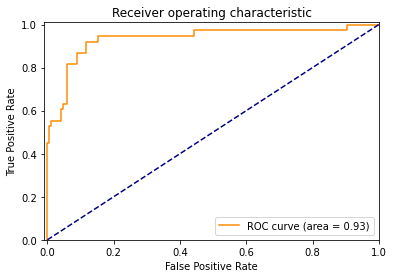

In [13]:
# This Validation-ROC is for the intial model
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [14]:
# Fine tune over 3 epochs using lr.find()
mdl.fit_one_cycle(5, max_lr = slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.490687,1.599812,0.364035,0.635965,02:03
1,0.405741,1.297622,0.302632,0.697368,02:02
2,0.347384,1.479822,0.346491,0.653509,02:02
3,0.280895,1.360507,0.320175,0.679825,02:03
4,0.222455,1.166976,0.298246,0.701754,02:03


In [15]:

# Save the model
mdl.save('stage-2')


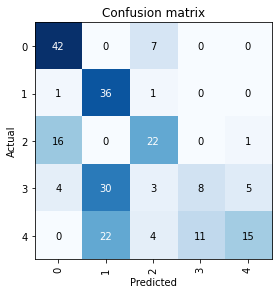

In [16]:
model = learn.load('stage-1')
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

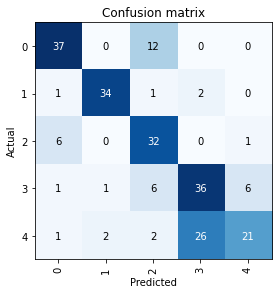

In [17]:
new_model = mdl.load('stage-2')
interp = ClassificationInterpretation.from_learner(new_model)
interp.plot_confusion_matrix()

In [18]:

mdl.export()

OSError: [Errno 30] Read-only file system: '../input/idriddata/Data/export.pkl'

The accuracy is 70.1754379272461 %.
ROC area is 0.9738227146814404


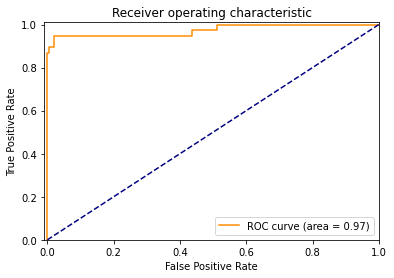

In [19]:
preds, y, loss = new_model.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc*100))
from sklearn.metrics import roc_curve, auc

# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [20]:
test_path='../input/idriddata/Data/testRG/'
test_files = get_image_files(test_path)
# test_dl = dls.test_dl(test_files)
#test_dl = new_model.dls.test_dl(test_files, with_label=True)

In [21]:
test_files

[]

In [ ]:

pred_probas, _, pred_classes = new_model.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
# Converted to numpy array
import numpy as np
preds = np.round(pred_probas,0)
preds = preds.numpy()
pred_classes = pred_classes.numpy()

In [ ]:

print(type(pred_probas),type(pred_classes))

In [ ]:
# test ROC for the fine tuned model

from sklearn.metrics import roc_curve, auc

# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(pred_classes, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")